# 4 Dynamic Centrality Analysis

## 4.0 准备工作

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
from lib.my_graph import MyGraph
from lib.my_graph import *

import matplotlib.pyplot as plt
import scienceplots
#plt.style.use(['science'])

import warnings
warnings.filterwarnings ( "ignore" )


In [2]:
%load_ext autoreload
%autoreload 2

标准化函数：

In [3]:
def normalization(arr):
    norm = np.linalg.norm(arr, ord=2)
    return np.abs(arr)/norm

### 4.0.0 $p=0$ (static network)

static的特征向量使用adj_matrix直接计算principle_eigenvector

特征向量和特征值的函数：

In [4]:
def principle_eigen(matrix):
    eigenvalue, eigenmatrix = np.linalg.eig(matrix)
    principle_eigenvalue = eigenvalue[0]
    principle_eigenvector = eigenmatrix[:,0]
    return principle_eigenvalue, principle_eigenvector

In [5]:
p_0_eigen_df=pd.DataFrame()
for date in tqdm(np.sort(os.listdir('output/21nodes_200day_p4_q2/eigenvector/'))[::1]):
    if '.ipynb_c' in date: continue
    adj_matrix_df=pd.read_csv('output/21nodes_200day_p4_q2/adjacent_matrix/%s' %date,index_col=0)
    #g = MyGraph(adj_matrix_df)
    principle_eigenvalue, principle_eigenvector = principle_eigen(adj_matrix_df)
    principle_eigenvector = np.abs(principle_eigenvector)
    p_0_eigen_df[date.split('.csv')[0]] = pd.Series(principle_eigenvector, index=adj_matrix_df.index)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3112/3112 [00:18<00:00, 171.54it/s]


### 4.0.1 fixed $p$

In [6]:
p_fixed_eigen_df=pd.DataFrame()
adj_matrix_list = []
p = 3
for date in tqdm(np.sort(os.listdir('output/21nodes_200day_p4_q2/eigenvector/'))[::1]):
    if '.ipynb_c' in date: continue
    adj_matrix_df=pd.read_csv('output/21nodes_200day_p4_q2/adjacent_matrix/%s' %date,index_col=0)
    if len(adj_matrix_list) >= p-1: 
        for i in range(len(adj_matrix_list)): 
            adj_matrix_df += adj_matrix_list[i]
        adj_matrix_df = adj_matrix_df/p
        adj_matrix_list.pop(0)
    adj_matrix_list.append(adj_matrix_df)
    principle_eigenvalue, principle_eigenvector = principle_eigen(adj_matrix_df)
    principle_eigenvector = np.abs(principle_eigenvector)
    p_fixed_eigen_df[date.split('.csv')[0]] = pd.Series(principle_eigenvector, index=adj_matrix_df.index)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3112/3112 [00:07<00:00, 397.77it/s]


### 4.0.3 dynamic $p_t$

In [7]:
p_dynamic_eigen_df=pd.DataFrame()
for date in tqdm(np.sort(os.listdir('output/21nodes_200day_p4_q2/eigenvector/'))[::1]):
    if '.ipynb_c' in date: continue
    p_dynamic_eigen_df[date.split('.csv')[0]] = pd.read_csv('output/21nodes_200day_p4_q2/eigenvector/%s' %date,index_col=0)['0']

p_dynamic_eigen_df[p_dynamic_eigen_df==0.] = np.nan
p_dynamic_eigen_df = p_dynamic_eigen_df.dropna(axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3112/3112 [00:17<00:00, 175.65it/s]


## 4.1 Centrality Separability Analysis

In [285]:
list_df = pd.read_excel('datasets/指数数据表.xlsx', dtype={'指数编码':np.str_})
list_df.index=list_df['指数名称']

### 异常值修正

对动态p的特征向量值直接求均值，会出现以下问题，例如异常值较多

<Axes: >

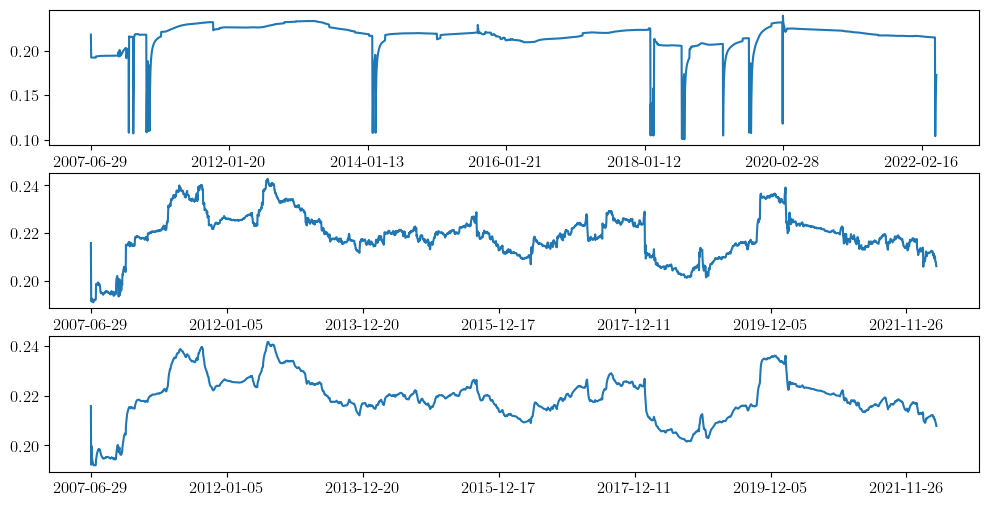

In [166]:
fig, ax = plt.subplots(3,1, figsize=(12, 6))
p_dynamic_eigen_df.T['标普500'].plot(ax=ax[0])
p_0_eigen_df.T['标普500'].plot(ax=ax[1])
p_fixed_eigen_df.T['标普500'].plot(ax=ax[2])

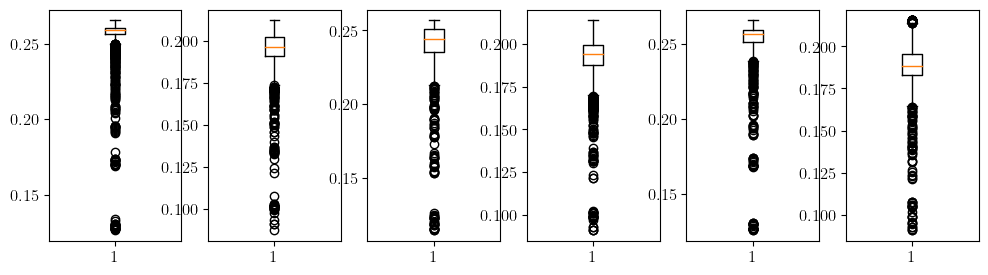

In [167]:
import seaborn as sns
nrows = 1
ncols = 6
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 3))
index = 0
ax = ax.flatten()
df = p_dynamic_eigen_df.T
for col, value in df.items():
    if index>ncols*nrows-1: break
    ax[index].boxplot(df[col])
    #ax[index].set_xlabel(col)
    index += 1
#plt.tight_layout(pad = 0.5, w_pad=0.7, h_pad=5.0)

In [168]:
import numpy as np
def processing(df):
    QU = df.quantile(0.75)
    QL = df.quantile(0.25)
    IQR = QU - QL
    df[df>(QU + 1.5*IQR)] = np.nan
    df = df.fillna(QU + 1.5*IQR)
    df[df<(QU - 1.5*IQR)] = np.nan
    df = df.fillna(QU - 1.5*IQR)
    return df

In [169]:
processing_p_0_eigen_df = p_0_eigen_df.T
processing_p_fixed_eigen_df = p_fixed_eigen_df.T
#processing_p_0_eigen_df = processing(p_0_eigen_df.abs().T)
#processing_p_fixed_eigen_df = processing(p_fixed_eigen_df.abs().T)
processing_p_dynamic_eigen_df = processing(p_dynamic_eigen_df.abs().T)

分位数异常值修正后：

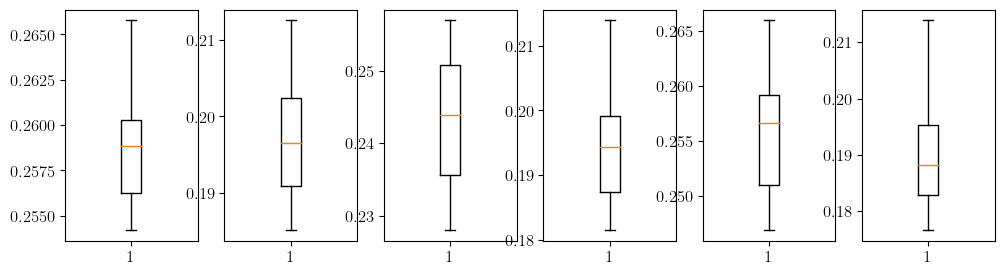

In [170]:
import seaborn as sns
nrows = 1
ncols = 6
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 3))
index = 0
ax = ax.flatten()
df = processing_p_dynamic_eigen_df
for col, value in df.items():
    if index>ncols*nrows-1: break
    ax[index].boxplot(df[col])
    #ax[index].set_xlabel(col)
    index += 1
#plt.tight_layout(pad = 0.5, w_pad=0.7, h_pad=5.0)

以及：

<Axes: >

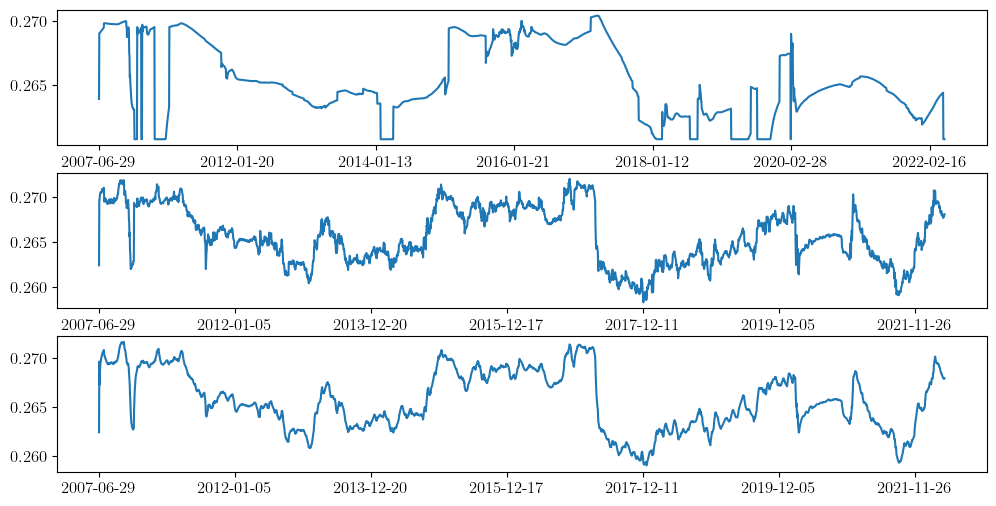

In [177]:
fig, ax = plt.subplots(3,1, figsize=(12, 6))
processing_p_dynamic_eigen_df['法国CAC40'].plot(ax=ax[0])
processing_p_0_eigen_df['法国CAC40'].plot(ax=ax[1])
processing_p_fixed_eigen_df['法国CAC40'].plot(ax=ax[2])

In [305]:
std_df = pd.DataFrame()
vs_df = pd.DataFrame()
vs_df['p=0'] = processing_p_0_eigen_df.mean(axis=0)
vs_df['p=0 std'] = (processing_p_0_eigen_df.std() * 2.)
vs_df['p=3'] = processing_p_fixed_eigen_df.mean(axis=0)
vs_df['p=3 std'] = (processing_p_fixed_eigen_df.std() * 2.)
vs_df['p=p_t'] = processing_p_dynamic_eigen_df.mean(axis=0)
vs_df['p=p_t std'] = (processing_p_dynamic_eigen_df.std() * 2.)

### 分区域显示$p=0,3,p_t$中心性

In [335]:
def print_latex_table(c):
    print('-'*50)
    for i in c.index:
        a = ' %s, %s &  %.5f ($\pm $%.5f) &   %.5f ($\pm $%.5f) &   %.5f ($\pm $%.5f) \\\\' %(list_df['国家全称EN'][i], list_df['指数编码'][i],
                                      c.loc[i, 'p=0'], c.loc[i, 'p=0 std'],
                                     c.loc[i, 'p=3'], c.loc[i, 'p=3 std'],
                                     c.loc[i, 'p=p_t'], c.loc[i, 'p=p_t std'],
                                    )
        print(a.replace('S&P500', 'S\&P500'))

In [336]:
print_latex_table(vs_df.loc[list_df['区域'][list_df['区域']=='美洲'].index].sort_values(by='p=0', ascending=False))

print_latex_table(vs_df.loc[list_df['区域'][list_df['区域']=='欧洲'].index].sort_values(by='p=0', ascending=False))

print_latex_table(vs_df.loc[list_df['区域'][list_df['区域']=='亚太'].index].sort_values(by='p=0', ascending=False))

--------------------------------------------------
 America, S\&P500 &  0.21908 ($\pm $0.01857) &   0.21907 ($\pm $0.01845) &   0.21874 ($\pm $0.01486) \\
 Canada, TSX &  0.21794 ($\pm $0.01598) &   0.21794 ($\pm $0.01585) &   0.21790 ($\pm $0.01729) \\
 Mexico, MXX &  0.20561 ($\pm $0.01841) &   0.20562 ($\pm $0.01830) &   0.20610 ($\pm $0.01533) \\
 Chile, IPSA &  0.20082 ($\pm $0.01647) &   0.20086 ($\pm $0.01627) &   0.20098 ($\pm $0.01531) \\
 Brazil, IBOV &  0.19983 ($\pm $0.02314) &   0.19986 ($\pm $0.02304) &   0.20029 ($\pm $0.02568) \\
 Colombia, WICOLL &  0.19054 ($\pm $0.01662) &   0.19057 ($\pm $0.01628) &   0.19052 ($\pm $0.01511) \\
 Costa Rica, IACR &  0.15530 ($\pm $0.02505) &   0.15528 ($\pm $0.02495) &   0.15159 ($\pm $0.02281) \\
--------------------------------------------------
 French, CAC40 &  0.26566 ($\pm $0.00608) &   0.26566 ($\pm $0.00600) &   0.26539 ($\pm $0.00570) \\
 Netherlands, AEX &  0.26270 ($\pm $0.00957) &   0.26270 ($\pm $0.00950) &   0.26193 ($\

### Separability Plots

最小最大标准化函数：

In [4]:
def standard(arr):
    return (arr - arr.min())/(arr.max() - arr.min())

In [27]:
bar_df = pd.DataFrame()
bar_df['$p=0$'] = standard(np.log(vs_df))['$p=0$'].sort_values(ascending=False).values
bar_df['$p=3$'] = standard(np.log(vs_df))['$p=3$'].sort_values(ascending=False).values
bar_df['$p=p_t$'] = standard(np.log(vs_df))['$p=p_t$'].sort_values(ascending=False).values
bar_df.index = np.arange(1, len(bar_df)+1)

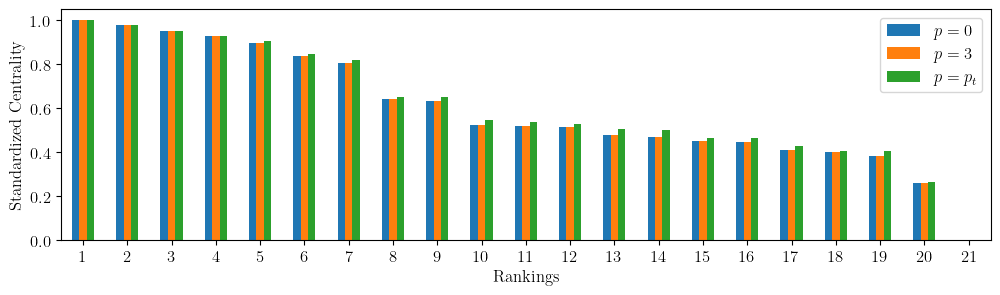

In [28]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.size":12
})
fig, ax= plt.subplots(figsize=(12,3))
bar_df.plot(ax=ax, kind='bar')
ax.set_xticklabels(labels=bar_df.index, rotation=0)
ax.set_ylabel('Standardized Centrality')
ax.set_xlabel('Rankings')
plt.savefig('images/Standardized Eigenvector Centrality.pdf')

## 4.2 Centrality Rankings Stability Analysis

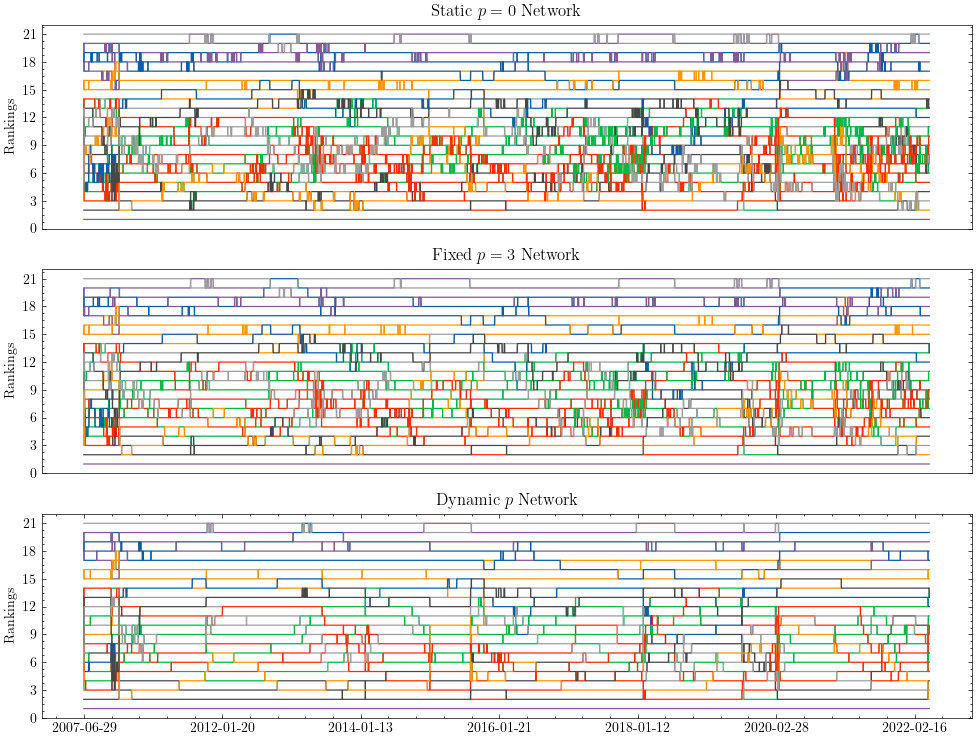

In [8]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times New Roman",
#     "font.size":12
# })
plt.style.use('science')

fig, ax = plt.subplots(3,1, figsize=(12,9))

p_0_eigen_df.loc[:, p_dynamic_eigen_df.columns].rank().T.plot(ax=ax[0],  legend=False, linewidth=.9)
p_fixed_eigen_df.loc[:, p_dynamic_eigen_df.columns].rank().T.plot(ax=ax[1],  legend=False, linewidth=.9)
p_dynamic_eigen_df.rank().T.plot(ax=ax[2], legend=False, linewidth=.9)

ax[0].set_title(label='Static $p=0$ Network')
#ax[1].set_xlabel(xlabel='dates', fontsize=12)
ax[0].set_xticks([])
ax[0].set_xticklabels([])
ax[0].set_yticks(np.arange(0, 22, 3))
ax[0].set_ylabel(ylabel='Rankings')

ax[1].set_title(label='Fixed $p=%s$ Network' %p)
ax[1].set_yticks(np.arange(0, 22, 3))
ax[1].set_xticks([])
ax[1].set_xticklabels([])
ax[1].set_ylabel(ylabel='Rankings')

ax[2].set_title(label='Dynamic $p$ Network')
ax[2].set_yticks(np.arange(0, 22, 3))
ax[2].set_ylabel(ylabel='Rankings')

plt.savefig('images/ranking_p_0_%s_dynamic.pdf' %p)

### Dynamic Nodes Significance Ranks Analysis
动态节点重要性：不同的网络表示方法可能突出不同的节点特征，从而导致特征向量中心性结果的差异。

通过比较不同方法计算得到的中心性值，我们的网络

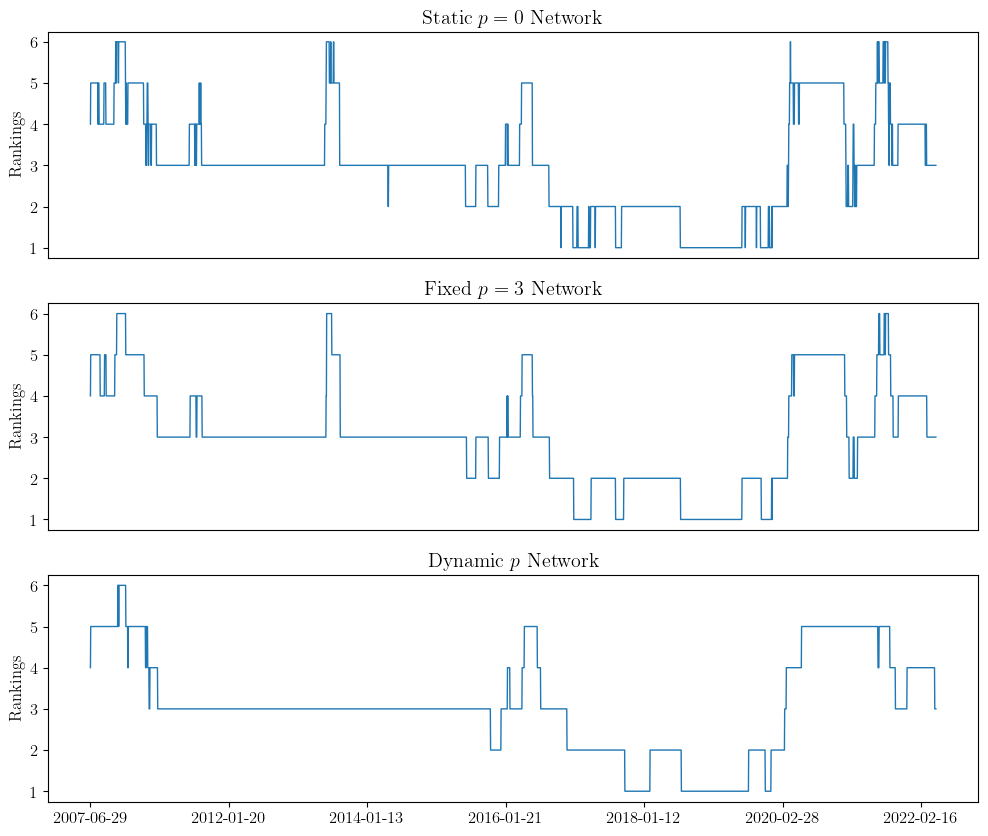

In [178]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.size":12
})

fig, ax = plt.subplots(3,1, figsize=(12,9))

p_0_eigen_df.loc[list_df['区域'][list_df['区域']=='欧洲'].index, :].rank().T['英国富时100'].plot(ax=ax[0],  legend=False, linewidth=1)
p_fixed_eigen_df.loc[list_df['区域'][list_df['区域']=='欧洲'].index, :].rank().T['英国富时100'].plot(ax=ax[1],  legend=False, linewidth=1)
p_dynamic_eigen_df.loc[list_df['区域'][list_df['区域']=='欧洲'].index, :].rank().T['英国富时100'].plot(ax=ax[2], legend=False, linewidth=1)

ax[0].set_title(label='Static $p=0$ Network')
#ax[1].set_xlabel(xlabel='dates', fontsize=12)
ax[0].set_xticks([])
ax[0].set_xticklabels([])
ax[0].set_yticks(np.arange(1, 7, 1))
ax[0].set_ylabel(ylabel='Rankings')

ax[1].set_title(label='Fixed $p=%s$ Network' %p)
ax[1].set_yticks(np.arange(1, 7, 1))
ax[1].set_xticks([])
ax[1].set_xticklabels([])
ax[1].set_ylabel(ylabel='Rankings')

ax[2].set_title(label='Dynamic $p$ Network')
ax[2].set_yticks(np.arange(1, 7, 1))
ax[2].set_ylabel(ylabel='Rankings')

plt.savefig('images/UK Ranking of p_0_%s_dynamic.pdf' %p)

### Change of Dynamic Nodes Ranking Scores

In [14]:
def ranking_diff_stats(eigen_df):
    eigen = eigen_df.rank().T
    diff = eigen.diff(1)
    diff[diff==0] = np.nan
    d = {i:0 for i in range(1,22)}
    for i in range(1, diff.shape[0]):
        for j in range(diff.shape[1]):
            if not np.isnan(diff.iloc[i, j]):
                #print(int(temporal_eigen.iloc[i-1,j]))
                d[int(eigen.iloc[i-1,j])] += 1 #np.abs(diff.iloc[i, j])
    l_d = np.array([[i, d[i]/eigen_df.shape[1]] for i in d])
    
    return l_d

In [15]:
diff_p_0_eigen_avg_df = ranking_diff_stats(p_0_eigen_df)
diff_p_fixed_eigen_df = ranking_diff_stats(p_fixed_eigen_df)
diff_p_dynamic_eigen_avg_df = ranking_diff_stats(p_dynamic_eigen_df)

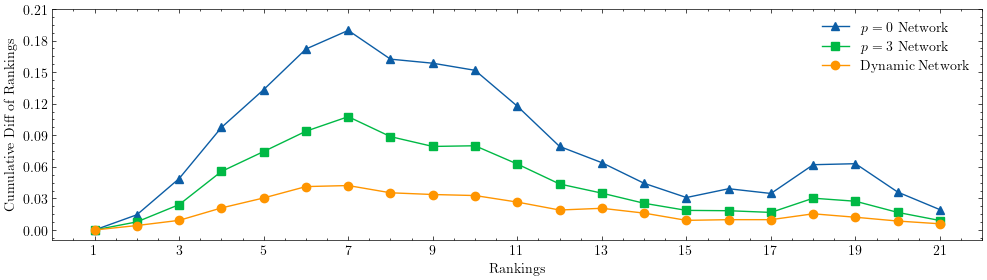

In [16]:
plt.style.use('science')
fig, ax=plt.subplots(figsize=(12,3))
ax.plot(diff_p_0_eigen_avg_df[:,0], diff_p_0_eigen_avg_df[:,1], marker='^', label='$p=0$ Network')
ax.plot(diff_p_fixed_eigen_df[:,0], diff_p_fixed_eigen_df[:,1], marker='s', label='$p=3$ Network')
ax.plot(diff_p_dynamic_eigen_avg_df[:,0], diff_p_dynamic_eigen_avg_df[:,1], marker='o', label='Dynamic Network')
ax.set_xticks(np.arange(1, 22, 2))
ax.set_yticks(np.arange(0, 0.22, 0.03))
ax.set_xlabel('Rankings')
ax.set_ylabel('Cumulative Diff of Rankings')
ax.legend()
plt.savefig('images/cumsum_diff_rankings.pdf')

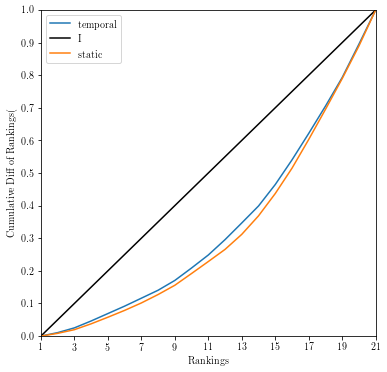

In [56]:
fig, ax=plt.subplots(figsize=(6,6))
temporal_df = pd.Series(temporal_d[:,1], index=temporal_d[:,0].ravel())
temporal_df = temporal_df.sort_values()
t = (temporal_df.cumsum()/temporal_df.sum())
t.index=np.arange(1,22)
t.plot(ax=ax, label='temporal')
I = pd.Series(np.linspace(0,1,21), index=temporal_d[:,0].ravel())
I.plot(ax=ax, label='I', color='black')
static_df = pd.Series(static_d[:,1], index=static_d[:,0].ravel())
static_df = static_df.sort_values()
t = (static_df.cumsum()/static_df.sum())
t.index=np.arange(1,22)
t.plot(ax=ax, label='static')
ax.set_xlabel('Rankings')
ax.set_ylabel('Cumulative Diff of Rankings(%)')
ax.set_xlim(1, 21)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(1, 22, 2))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.legend()

In [11]:
def spearman(eigen_df):
    spearman_df = eigen_df.corr(method='spearman')
    s = {}
    for i in range(1, spearman_df.shape[0]-1):
        date = spearman_df.index[i+1]
        s[date] = spearman_df.iloc[i, i+1]
    return s

In [12]:
s = pd.DataFrame()
s['$p=0$ Network'] = pd.Series(spearman(p_0_eigen_df))
s['$p=3$ Network'] = pd.Series(spearman(p_fixed_eigen_df))
s['Dynamic $p$ Network']= pd.Series(spearman(p_dynamic_eigen_df))

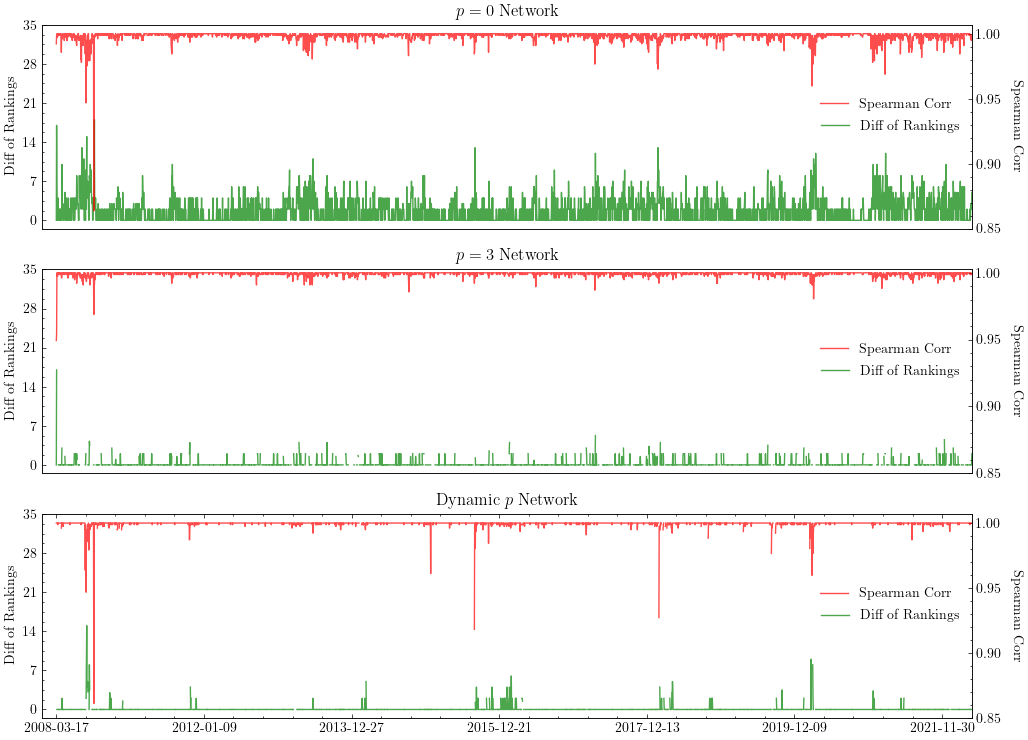

In [13]:
# plt.style.use('science')
fig, ax = plt.subplots(3,1, figsize=(12,9))

diff_rankings = (p_0_eigen_df.rank().T.diff(1).abs()/p_0_eigen_df.rank().T.diff(1).abs()).sum(axis=1)
#diff_rankings[diff_rankings == np.inf] = 0
#print(diff_rankings.mean())
diff_rankings.plot(ax=ax[0], kind='line', color='green', label='Diff of Rankings', alpha=0.7)
diff_rankings = (p_fixed_eigen_df.rank().T.diff(1).abs()/p_0_eigen_df.rank().T.diff(1).abs()).sum(axis=1)
#diff_rankings[diff_rankings == np.inf] = 0
#print(diff_rankings.mean())
diff_rankings.plot(ax=ax[1], kind='line', color='green', label='Diff of Rankings', alpha=0.7)
diff_rankings = (p_dynamic_eigen_df.rank().T.diff(1).abs()/p_0_eigen_df.rank().T.diff(1).abs()).sum(axis=1)
#diff_rankings[diff_rankings == np.inf] = 0
#print(diff_rankings.mean())
diff_rankings.plot(ax=ax[2], kind='line', color='green', label='Diff of Rankings', alpha=0.7)

ax[0].set_title('$p=0$ Network')
ax[0].set_ylabel('Diff of Rankings')
ax[1].set_title('$p=3$ Network')
ax[1].set_ylabel('Diff of Rankings')
ax[2].set_title('Dynamic $p$ Network')
ax[2].set_ylabel('Diff of Rankings')
ax[0].set_yticks(np.arange(0, 36, 7))
ax[1].set_yticks(np.arange(0, 36, 7))
ax[2].set_yticks(np.arange(0, 36, 7))
ax[0].set_ylim(-1.5, 35)
ax[1].set_ylim(-1.5, 35)
ax[2].set_ylim(-1.5, 35)
ax[0].set_xlim(-50, 3100)
ax[1].set_xlim(-50, 3100)
ax[2].set_xlim(-50, 3100)
ax[0].set_xticks([])
ax[0].set_xticklabels([])
ax[1].set_xticks([])
ax[1].set_xticklabels([])
axx = ax[0].twinx()
s['$p=0$ Network'].plot(ax=axx, kind='line', label='Spearman Corr', color='red', alpha=0.7)
axx.set_ylabel('Spearman Corr', rotation=-90, labelpad=16)
axx.set_yticks(np.arange(0.85, 1.01, 0.05))
# ---------
axx2 = ax[1].twinx()
s['$p=3$ Network'].plot(ax=axx2, kind='line', label='Spearman Corr', color='red', alpha=0.7)
axx2.set_ylabel('Spearman Corr', rotation=-90, labelpad=16)
axx2.set_yticks(np.arange(0.85, 1.01, 0.05))
# ---------
axx3 = ax[2].twinx()
s['Dynamic $p$ Network'].plot(ax=axx3, kind='line', label='Spearman Corr', color='red', alpha=0.7)
axx3.set_ylabel('Spearman Corr', rotation=-90, labelpad=16)
axx3.set_yticks(np.arange(0.85, 1.01, 0.05))

ax[0].legend(loc='center right')
ax[1].legend(loc='center right')
ax[2].legend(loc='center right')

axx.legend(bbox_to_anchor = (0.9925, .7))
axx2.legend(bbox_to_anchor = (0.9925, .7))
axx3.legend(bbox_to_anchor = (0.9925, .7))
plt.savefig('images/diff_rankings.pdf')

## relationship

In [24]:
eigen_df=pd.DataFrame()
eigen_corr = {}
for date in tqdm(np.sort(os.listdir('output/21nodes_200day_p4_q2/eigenvector/'))[::1]):
    if '.ipynb_c' in date: continue
    eigen_df['temporal'] = pd.read_csv('output/21nodes_200day_p4_q2/eigenvector/%s' %date,index_col=0)['0']
    
    adj_matrix_df=pd.read_csv('output/21nodes_200day_p4_q2/adjacent_matrix/%s' %date,index_col=0)
    g = MyGraph(adj_matrix_df)
    rinciple_eigenvalue, principle_eigenvector = principle_eigen(adj_matrix_df)
    principle_eigenvector = np.abs(principle_eigenvector)
    eigen_df['static'] = pd.Series(principle_eigenvector, index=adj_matrix_df.index)
    if eigen_df.isna().any().any() : continue
    eigen_corr[date] = eigen_df.corr().values[0,1]

100%|██████████| 3112/3112 [02:09<00:00, 24.06it/s]


In [77]:
eigen_df

,temporal,static
德国DAX,0.223009,0.267850
孟买Sensex30,0.179264,0.215163
西班牙IBEX35,0.205087,0.246153
澳大利亚标普200指数,0.166004,0.199442
比利时BFX,0.213798,0.256806
日经225,0.165452,0.199039
墨西哥BOLSA,0.166307,0.198845
英国富时100,0.211488,0.254062
恒生指数,0.167622,0.201790
瑞士SMI,0.207428,0.249569


In [78]:
eigen_df.sort_values(by='temporal').rank()#.plot()

,temporal,static
Costa Rica Indice Accionario,1.0,1.0
FTSE Colombia,2.0,2.0
S&P CLX IPSA,3.0,3.0
上证指数,4.0,4.0
巴西IBOVESPA,5.0,5.0
富时新加坡海峡时报,6.0,6.0
日经225,7.0,8.0
澳大利亚标普200指数,8.0,9.0
墨西哥BOLSA,9.0,7.0
韩国综合指数,10.0,10.0


<AxesSubplot:>

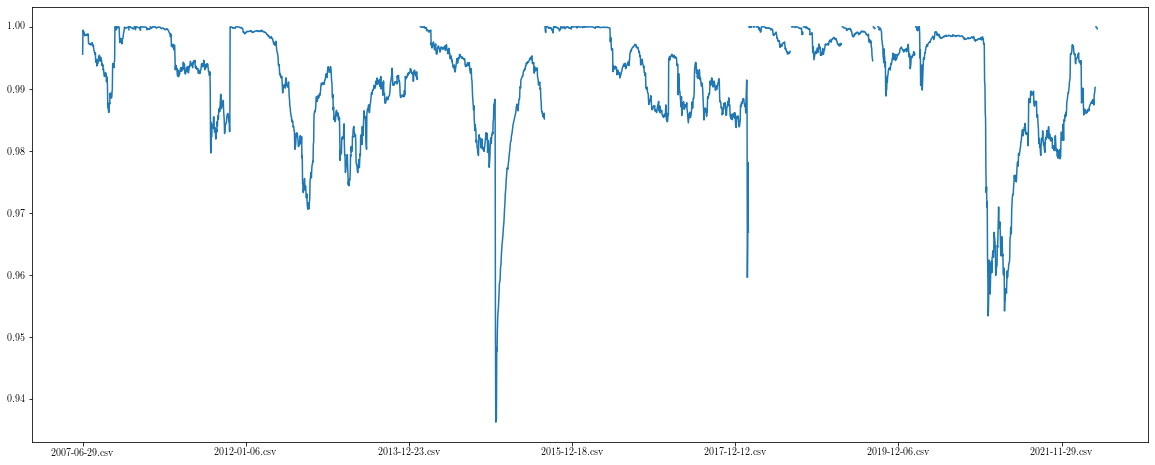

In [26]:
ec = pd.Series(eigen_corr)
ec.plot(figsize=(20,8), legend=False)

In [80]:
#e = eigen_df.sort_values(by='temporal').rank()
#eigen_df['temporal'].rank()
jaccard(eigen_df['temporal'].rank()[:10], eigen_df['static'].rank()[:10])#.values)

1.0

In [81]:
eigen_df.sort_values(by='temporal').rank()

,temporal,static
Costa Rica Indice Accionario,1.0,1.0
FTSE Colombia,2.0,2.0
S&P CLX IPSA,3.0,3.0
上证指数,4.0,4.0
巴西IBOVESPA,5.0,5.0
富时新加坡海峡时报,6.0,6.0
日经225,7.0,8.0
澳大利亚标普200指数,8.0,9.0
墨西哥BOLSA,9.0,7.0
韩国综合指数,10.0,10.0


In [82]:
ec[ec<0.96]

2015-01-15.csv    0.951440
2015-01-16.csv    0.936329
2015-01-19.csv    0.936412
2015-01-20.csv    0.936981
2015-01-21.csv    0.948344
2015-01-22.csv    0.947804
2015-01-23.csv    0.951142
2015-01-26.csv    0.953313
2015-01-27.csv    0.954134
2015-01-28.csv    0.954632
2015-01-29.csv    0.955725
2015-01-30.csv    0.957065
2015-02-02.csv    0.958583
2015-02-03.csv    0.958906
2015-02-04.csv    0.959036
2018-02-06.csv    0.959640
2021-01-12.csv    0.959802
2021-01-13.csv    0.953446
2021-01-14.csv    0.955051
2021-01-15.csv    0.958618
2021-01-21.csv    0.956966
2021-01-22.csv    0.959124
2021-02-15.csv    0.959961
2021-03-24.csv    0.954236
2021-03-25.csv    0.955886
2021-03-26.csv    0.955907
2021-03-29.csv    0.957169
2021-03-30.csv    0.957574
2021-03-31.csv    0.957875
2021-04-01.csv    0.957129
2021-04-06.csv    0.958955
2021-04-08.csv    0.959613
2021-04-09.csv    0.959945
dtype: float64

## Jaccard Similarity

In [83]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union
# e.g.
a = [0, 1, 2, 8, 6, 5, 9]
b = [0, 2, 1, 6, 5, 8, 9]
jaccard(a[:5], b[:5])

0.6666666666666666

### Static Network

In [84]:
adj_matrix = pd.read_csv('output/21nodes_200day_p4_q2/adjacent_matrix/2020-06-29.csv', index_col=0)
#adj_matrix[adj_matrix <0.4] = 0

In [85]:
import os
from tqdm import tqdm
#eigenvector_df=pd.DataFrame()
n = 0
for date in tqdm(np.sort(os.listdir('output/21nodes_200day_p4_q2/adjacent_matrix/'))[-10:]):
    if '.ipynb_c' in date: continue
    adj_matrix=pd.read_csv('output/21nodes_200day_p4_q2/adjacent_matrix/%s' %date,index_col=0)
    # eigen
    #rinciple_eigenvalue, principle_eigenvector = principle_eigen(adj_matrix)
    #df = pd.DataFrame(principle_eigenvector, columns=[date.split('.csv')[0]], index=adj_matrix.index)
    #eigenvector_df=pd.concat([eigenvector_df, df.T])
    # adj
    if n == 0:
        adj_matrix_sum = adj_matrix.fillna(0)
    else:
        adj_matrix_sum = adj_matrix_sum+adj_matrix.fillna(0)
    n = n+1

100%|██████████| 10/10 [00:00<00:00, 442.60it/s]


In [86]:
adj_matrix_df = adj_matrix_sum/n
#adj_matrix_df
#adj_matrix_df[adj_matrix_df <0.1] = 0

In [87]:
# eigenvector_df[eigenvector_df==0] = np.nan
# eigenvector_df = eigenvector_df.fillna(method='ffill')
# eigenvector_df = np.abs(eigenvector_df)
# jingtai_eigen_center = eigenvector_df.iloc[-3500:].mean()

In [88]:
g = MyGraph(adj_matrix_df)
# jingtai_eigen_center = cal_eigenvector_centrality(g.g)
# jingtai_eigen_df = pd.Series(jingtai_eigen_center, index=adj_matrix_df.index)

In [89]:
rinciple_eigenvalue, principle_eigenvector = principle_eigen(adj_matrix_df)
jingtai_eigen_df = pd.Series(principle_eigenvector, index=adj_matrix_df.index)
jingtai_eigen_df

德国DAX                           0.267624
孟买Sensex30                      0.214987
西班牙IBEX35                       0.246351
澳大利亚标普200指数                     0.198932
比利时BFX                          0.256924
日经225                           0.198050
墨西哥BOLSA                        0.200609
英国富时100                         0.254060
恒生指数                            0.200864
瑞士SMI                           0.248710
韩国综合指数                          0.199125
荷兰AEX                           0.260370
上证指数                            0.185252
法国CAC40                         0.267880
标普500                           0.208747
富时新加坡海峡时报                       0.198282
FTSE Colombia                   0.174863
巴西IBOVESPA                      0.194859
Costa Rica Indice Accionario    0.160121
加拿大多伦多S&P/TSX 综合指数              0.215472
S&P CLX IPSA                    0.180671
dtype: float64

In [90]:
jacard_dict = {}
jacard_dict['Static Network'] = {}
num = 10
jacard_dict['Static Network']['Degree Centrality']=jaccard(np.argsort(jingtai_eigen_df)[:num], 
                                                    np.argsort(cal_degree(g.adj_matrix))[:num])
jacard_dict['Static Network']['Closeness Centrality']=jaccard(np.argsort(jingtai_eigen_df)[:num],
                                                    np.argsort(-1.*np.array(cal_closeness(g.g)))[:num])
jacard_dict['Static Network']['Betweenness Centrality']=jaccard(np.argsort(jingtai_eigen_df)[:num], 
                                                    np.argsort(cal_betweenness(g.g))[:num])

In [91]:
pd.DataFrame(jacard_dict).T

,Betweenness Centrality,Closeness Centrality,Degree Centrality
Static Network,0.333333,1.0,0.333333


### Temporal Network

In [92]:
#df = pd.read_csv('output/21nodes_200day_p4_q2/eigenvector/2020-06-29.csv', index_col=0)
#df = df['0']

使用平均eigenvector

In [93]:
temporal_eigen_df=pd.DataFrame()
for date in tqdm(np.sort(os.listdir('output/21nodes_200day_p4_q2/eigenvector/'))[-10:]):
    if '.ipynb_c' in date: continue
    eigenvector=pd.read_csv('output/21nodes_200day_p4_q2/eigenvector/%s' %date,index_col=0)
    eigenvector.columns = [date.split('.csv')[0]]
    temporal_eigen_df=pd.concat([temporal_eigen_df, eigenvector.T])

100%|██████████| 10/10 [00:00<00:00, 544.87it/s]


In [94]:
temporal_eigen_df = temporal_eigen_df.mean()

In [95]:
jacard_dict['Temporal Network'] = {}
num = 10
adj = g.adj_matrix.copy()
#adj[adj<0.3] = 0
jacard_dict['Temporal Network']['Degree Centrality']=jaccard(np.argsort(temporal_eigen_df.values)[:num], 
                                                    np.argsort(cal_degree(adj))[:num])
jacard_dict['Temporal Network']['Closeness Centrality']=jaccard(np.argsort(temporal_eigen_df.values)[:num],
                                                    np.argsort(-1.*np.array(cal_closeness(g.g)))[:num])
jacard_dict['Temporal Network']['Betweenness Centrality']=jaccard(np.argsort(temporal_eigen_df.values)[:num], 
                                                    np.argsort(cal_betweenness(g.g))[:num])

In [96]:
jacard_df = pd.DataFrame(jacard_dict).T
jacard_df.index.name = 'Jacard Similarity'
jacard_df

,Degree Centrality,Closeness Centrality,Betweenness Centrality
Jacard Similarity,,,
Static Network,0.333333,1.000000,0.333333
Temporal Network,0.333333,0.818182,0.333333


### Jacard Plots

In [97]:
static_dict = {}
temporal_dict = {}
for num in range(1, 22):
    static_dict[num] = jaccard(np.argsort(jingtai_eigen_df)[:num], 
                                np.argsort(cal_degree(g.adj_matrix))[:num])
    temporal_dict[num] = jaccard(np.argsort(temporal_eigen_df.values)[:num], 
                                np.argsort(cal_degree(g.adj_matrix))[:num])
jacard={}
jacard['static'] = static_dict
jacard['temporal'] = temporal_dict
jacard_degree = pd.DataFrame(jacard)
jacard_degree.index.name = 'ranking'
jacard_degree.name = 'Jaccard Similarity'
jacard_degree.index = jacard_degree.index.astype(int)

closeness

In [98]:
static_dict = {}
temporal_dict = {}
for num in range(1, 22):
    static_dict[num] = jaccard(np.argsort(jingtai_eigen_df)[:num],
                                np.argsort(-1.*np.array(cal_closeness(g.g)))[:num])
    temporal_dict[num] =jaccard(np.argsort(temporal_eigen_df.values)[:num],
                                np.argsort(-1.*np.array(cal_closeness(g.g)))[:num])
    #print(np.argsort(temporal_eigen_df)[:num], np.argsort(-1.*np.array(cal_closeness(g.g)))[:num])
jacard={}
jacard['static'] = static_dict
jacard['temporal'] = temporal_dict
jacard_closeness = pd.DataFrame(jacard)
jacard_closeness.index.name = 'ranking'
jacard_closeness.name = 'Jaccard Similarity'
jacard_closeness.index = jacard_closeness.index.astype(int)

betweenness

In [99]:
static_dict = {}
temporal_dict = {}
for num in range(1, 22):
    static_dict[num] = jaccard(np.argsort(jingtai_eigen_df)[:num], 
                                np.argsort(cal_betweenness(g.g))[:num])
    temporal_dict[num] =jaccard(np.argsort(temporal_eigen_df.values)[:num], 
                                np.argsort(cal_betweenness(g.g))[:num])
jacard={}
jacard['static'] = static_dict
jacard['temporal'] = temporal_dict
jacard_betweenness = pd.DataFrame(jacard)
jacard_betweenness.index.name = 'ranking'
jacard_betweenness.name = 'Jaccard Similarity'
jacard_betweenness.index = jacard_betweenness.index.astype(int)

Text(0, 0.5, 'Jaccard Similarity')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


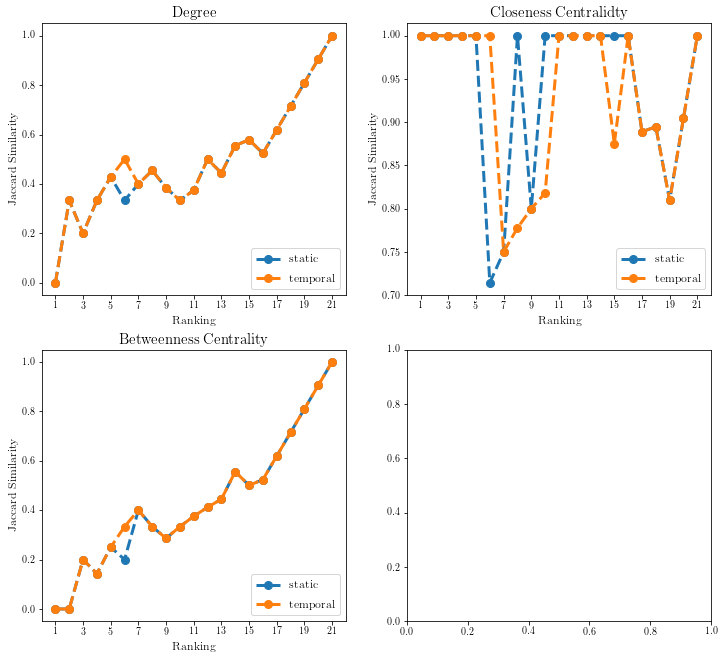

In [100]:
fig, ax = plt.subplots(2,2, figsize=(12,11))
jacard_degree.plot(ax=ax[0][0], xticks=jacard_degree.index[::2], 
                  linestyle='--', linewidth=3, marker='o',markersize=8)
jacard_closeness.plot(ax=ax[0][1], xticks=jacard_closeness.index[::2],
                  linestyle='--', linewidth=3, marker='o',markersize=8)
jacard_betweenness.plot(ax=ax[1][0], xticks=jacard_betweenness.index[::2],
                  linestyle='--', linewidth=3, marker='o',markersize=8)
ax[0][0].legend(loc='lower right', fontsize=12)
ax[0][0].set_title(label='Degree', fontsize=15)
ax[0][0].set_xlabel(xlabel='Ranking', fontsize=12)
ax[0][0].set_ylabel(ylabel='Jaccard Similarity', fontsize=12)

ax[0][1].legend(loc='lower right', fontsize=12)
ax[0][1].set_title(label='Closeness Centralidty', fontsize=15)
ax[0][1].set_xlabel(xlabel='Ranking', fontsize=12)
ax[0][1].set_ylabel(ylabel='Jaccard Similarity', fontsize=12)

ax[1][0].legend(loc='lower right', fontsize=12)
ax[1][0].set_title(label='Betweenness Centrality', fontsize=15)
ax[1][0].set_xlabel(xlabel='Ranking', fontsize=12)
ax[1][0].set_ylabel(ylabel='Jaccard Similarity', fontsize=12)

### 遍历过去1000天的静态static

In [101]:
for num in range(8, 22):
    degree[date][num] = jaccard(np.argsort(temporal_eigen)[:num], 
                                np.argsort(cal_degree(g.adj_matrix))[:num])

NameError: name 'temporal_eigen' is not defined

In [ ]:
def plot(date_idx):
    jacard_degree, jacard_closeness, jacard_betweenness = pd.DataFrame(), \
                                                      pd.DataFrame(),pd.DataFrame()

    degree, closeness, betweenness={},{},{}
    n = 0
    for date in tqdm(np.sort(os.listdir('output/21nodes_200day_p4_q2/adjacent_matrix/'))[date_idx-1:date_idx]):
    #for date in ['2012-12-03.csv']:
    #for date in ['2008-04-10.csv']:
        if '.ipynb_c' in date: continue
        #
        adj_matrix_df=pd.read_csv('output/21nodes_200day_p4_q2/adjacent_matrix/%s' %date,index_col=0)
        if n == 0:
            adj_matrix_sum = adj_matrix.fillna(0)
        else:
            adj_matrix_sum = adj_matrix_sum+adj_matrix.fillna(0)
        n = n+1
    print(date)
    adj_matrix_df = adj_matrix_sum/n
    g = MyGraph(adj_matrix_df)
    rinciple_eigenvalue, principle_eigenvector = principle_eigen(adj_matrix_df)
    principle_eigenvector = np.abs(principle_eigenvector)
    jingtai_eigen_df = pd.Series(principle_eigenvector, index=adj_matrix_df.index)
    degree[date],  closeness[date], betweenness[date]= {}, {},{}
    for num in range(8, 22):
        degree[date][num] = 1-1/jaccard(np.argsort(jingtai_eigen_df)[:num], 
                                    np.argsort(cal_degree(g.adj_matrix))[:num])
        closeness[date][num] = 1-1/jaccard(np.argsort(jingtai_eigen_df)[:num],
                                    np.argsort(-1.*np.array(cal_closeness(g.g)))[:num])
        betweenness[date][num] = 1-1/jaccard(np.argsort(jingtai_eigen_df)[:num], 
                                np.argsort(cal_betweenness(g.g))[:num])

    jacard_degree['static'] = pd.DataFrame(degree).mean(axis=1)
    jacard_closeness['static'] = pd.DataFrame(closeness).mean(axis=1)
    jacard_betweenness['static'] = pd.DataFrame(betweenness).mean(axis=1)


    degree, closeness, betweenness={},{},{}
    #temporal_eigen_df=pd.DataFrame()
    #for date in tqdm(np.sort(os.listdir('output/21nodes_200day_p4_q2/eigenvector/'))[:100]):
    #for date in ['2008-11-13.csv']:
    #for date in ['2022-02-23.csv']:
    #if '.ipynb_c' in date: continue
    temporal_eigen_df=pd.read_csv('output/21nodes_200day_p4_q2/eigenvector/%s' %date,index_col=0)
    temporal_eigen = temporal_eigen_df.values[:,0]
    degree[date],  closeness[date], betweenness[date]= {}, {},{}
    for num in range(8, 21):
        degree[date][num] = 1-1/jaccard(np.argsort(temporal_eigen)[:num], 
                                    np.argsort(cal_degree(g.adj_matrix))[:num])
        closeness[date][num] = 1-1/jaccard(np.argsort(temporal_eigen)[:num],
                                    np.argsort(-1.*np.array(cal_closeness(g.g)))[:num])
        betweenness[date][num] = 1-1/jaccard(np.argsort(temporal_eigen)[:num], 
                                np.argsort(cal_betweenness(g.g))[:num])

    jacard_degree['temporal'] = pd.DataFrame(degree).mean(axis=1)
    jacard_closeness['temporal'] = pd.DataFrame(closeness).mean(axis=1)
    jacard_betweenness['temporal'] = pd.DataFrame(betweenness).mean(axis=1)


    fig, ax = plt.subplots(1,3, figsize=(18,4))
    jacard_degree.plot(ax=ax[0], xticks=jacard_degree.index[::2], 
                      linestyle='--', linewidth=3, marker='o',markersize=8)
    jacard_closeness.plot(ax=ax[1], xticks=jacard_closeness.index[::2],
                      linestyle='--', linewidth=3, marker='o',markersize=8)
    jacard_betweenness.plot(ax=ax[2], xticks=jacard_betweenness.index[::2],
                      linestyle='--', linewidth=3, marker='o',markersize=8)
    ax[0].legend(loc='lower right', fontsize=12)
    ax[0].set_title(label='Degree', fontsize=15)
    ax[0].set_xlabel(xlabel='Rankings', fontsize=12)
    ax[0].set_ylabel(ylabel='Jaccard Similarity', fontsize=12)

    ax[1].legend(loc='lower right', fontsize=12)
    ax[1].set_title(label='Closeness Centrality', fontsize=15)
    ax[1].set_xlabel(xlabel='Rankings', fontsize=12)
    ax[1].set_ylabel(ylabel='Jaccard Similarity', fontsize=12)

    ax[2].legend(loc='lower right', fontsize=12)
    ax[2].set_title(label='Betweenness Centrality', fontsize=15)
    ax[2].set_xlabel(xlabel='Rankings', fontsize=12)
    ax[2].set_ylabel(ylabel='Jaccard Similarity', fontsize=12)
    plt.show()
    #plt.savefig('image/Jaccard Similarity %s.png' %date, dpi=400)
    #plt.title(date)


In [ ]:
for date_idx in range(1500, 2000, 100):
    plot(date_idx=date_idx)